In [1]:
!pip -q install -U transformers accelerate scikit-learn
import torch
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 93.4 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 89.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB

# Install + Imports

# Configuration

In [8]:
# ==============================================================
# ⚙️ Configuration + Imports (Teacher: XLM-R, Student: DistilRoBERTa)
# ==============================================================

import os, json, random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW   # transformers >= 4.46

# ----------------------------
# Repro + device
# ----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# ----------------------------
# Paths
# ----------------------------
WORK_DIR = Path("/kaggle/working"); WORK_DIR.mkdir(exist_ok=True)
DATA_DIR = Path("/kaggle/input/dataaaaaa")  # adjust if your dataset path differs

# ----------------------------
# Models
# ----------------------------
TEACHER_MODEL_ID = "xlm-roberta-base"     # teacher to fine-tune
STUDENT_MODEL_ID = "distilroberta-base"   # 🔁 student switched to DistilRoBERTa

# ----------------------------
# Training params
# ----------------------------
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS_TEACHER = 3
EPOCHS_STUDENT = 10
LR_TEACHER = 2e-5
LR_STUDENT = 3e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
PATIENCE = 2

# ----------------------------
# KD hyperparameters
# ----------------------------
KD_T = 3.0
KD_ALPHA = 0.5
GAMMA_HIDDEN = 1.0
GAMMA_ATT   = 1.0

def compute_metrics(preds, labels):
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
    }

print(f"\nKD setup → T={KD_T}, α={KD_ALPHA}, γ_hidden={GAMMA_HIDDEN}, γ_att={GAMMA_ATT}\n")


✅ Using device: cuda

KD setup → T=3.0, α=0.5, γ_hidden=1.0, γ_att=1.0



# Split & Convert to Dataset

In [3]:
def read_lines(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

pos = read_lines(DATA_DIR / "all_positive_8500.txt")
neg = read_lines(DATA_DIR / "all_negative_3307.txt")

df = pd.concat([
    pd.DataFrame({"text": pos, "label": 1}),
    pd.DataFrame({"text": neg, "label": 0})
], ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

train_df, tmp_df = train_test_split(df, test_size=0.2, stratify=df.label, random_state=SEED)
val_df, test_df  = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df.label, random_state=SEED)

print(f"Split sizes → Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")


Split sizes → Train=9445, Val=1181, Test=1181


# Load Teacher (XLM-R) from Kaggle Input & Evaluate

In [4]:
teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_ID)

class SimpleDataset(Dataset):
    def __init__(self, df, tok, max_len):
        self.texts = df.text.tolist()
        self.labels = df.label.tolist()
        self.tk = tok; self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = self.tk(self.texts[i], truncation=True, max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

def pad_collate(batch, pad_id):
    keys = batch[0].keys(); out = {}
    for k in keys:
        if k == "labels": out[k] = torch.stack([b[k] for b in batch])
        else:
            pad_val = 0 if k == "attention_mask" else pad_id
            out[k] = nn.utils.rnn.pad_sequence([b[k] for b in batch], batch_first=True, padding_value=pad_val)
    return out

train_loader = DataLoader(SimpleDataset(train_df, teacher_tokenizer, MAX_LEN),
                          batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=lambda b: pad_collate(b, teacher_tokenizer.pad_token_id))
val_loader   = DataLoader(SimpleDataset(val_df, teacher_tokenizer, MAX_LEN),
                          batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda b: pad_collate(b, teacher_tokenizer.pad_token_id))
test_loader  = DataLoader(SimpleDataset(test_df, teacher_tokenizer, MAX_LEN),
                          batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda b: pad_collate(b, teacher_tokenizer.pad_token_id))

teacher = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_ID, num_labels=2).to(DEVICE)

opt_t = AdamW(teacher.parameters(), lr=LR_TEACHER, weight_decay=WEIGHT_DECAY)
steps_t = len(train_loader) * EPOCHS_TEACHER
warm_t  = int(WARMUP_RATIO * steps_t)
sched_t = get_linear_schedule_with_warmup(opt_t, warm_t, steps_t)

def evaluate_cls(model, loader):
    model.eval(); preds, gold = [], []
    with torch.no_grad():
        for b in loader:
            b = {k:v.to(DEVICE) for k,v in b.items()}
            out = model(**b)
            preds += out.logits.argmax(-1).detach().cpu().tolist()
            gold  += b["labels"].detach().cpu().tolist()
    return compute_metrics(np.array(preds), np.array(gold))

best_f1, wait = -1, 0
for ep in range(1, EPOCHS_TEACHER+1):
    teacher.train(); run_loss = 0.0
    for b in tqdm(train_loader, desc=f"[Teacher XLM-R] Epoch {ep}", leave=False):
        b = {k:v.to(DEVICE) for k,v in b.items()}
        out = teacher(**b)
        loss = out.loss
        loss.backward()
        nn.utils.clip_grad_norm_(teacher.parameters(), 1.0)
        opt_t.step(); sched_t.step(); opt_t.zero_grad()
        run_loss += loss.item()
    val = evaluate_cls(teacher, val_loader)
    print(f"Epoch {ep} | Loss={run_loss/len(train_loader):.4f} | Val F1={val['f1_macro']:.4f}")

    if val["f1_macro"] > best_f1:
        best_f1, wait = val["f1_macro"], 0
        teacher.save_pretrained(WORK_DIR / "finetuned_xlmr")
        teacher_tokenizer.save_pretrained(WORK_DIR / "finetuned_xlmr")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stop teacher."); break

# Reload best teacher & quick test check
teacher = AutoModelForSequenceClassification.from_pretrained(WORK_DIR / "finetuned_xlmr").to(DEVICE)
teacher_tokenizer = AutoTokenizer.from_pretrained(WORK_DIR / "finetuned_xlmr")
teacher_test = evaluate_cls(teacher, test_loader)
print("[Teacher XLM-R][Test]:", teacher_test)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2025-11-01 18:54:59.431404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762023299.630369      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762023299.690090      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Teacher XLM-R] Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 1 | Loss=0.3746 | Val F1=0.9411


[Teacher XLM-R] Epoch 2:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 2 | Loss=0.1633 | Val F1=0.9408


[Teacher XLM-R] Epoch 3:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 3 | Loss=0.1049 | Val F1=0.9507
[Teacher XLM-R][Test]: {'accuracy': 0.951735817104149, 'f1_macro': 0.9403485141846957, 'f1_weighted': 0.9518020223536807}


# Prepare for KD (Shared Tokenizer = Teacher’s)

In [5]:
# ==============================================================
# 📦 Prepare for Knowledge Distillation (Shared Tokenizer = Teacher's)
# ==============================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --------------------------------------------------------------
# 1️⃣  Load best fine-tuned teacher checkpoint (from Cell 4)
# --------------------------------------------------------------
TEACHER_DIR = WORK_DIR / "finetuned_xlmr"

if not TEACHER_DIR.exists():
    raise FileNotFoundError(f"❌ Fine-tuned teacher checkpoint not found at {TEACHER_DIR}")

teacher = AutoModelForSequenceClassification.from_pretrained(TEACHER_DIR).to(DEVICE)
teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_DIR)
teacher.eval()

print(f"✅ Loaded fine-tuned teacher from {TEACHER_DIR}")

# --------------------------------------------------------------
# 2️⃣  Shared tokenizer setup
# --------------------------------------------------------------
# We'll use the teacher tokenizer for both teacher and student to ensure consistent input IDs
shared_tok = teacher_tokenizer
print(f"🔄 Using shared tokenizer (vocab size={len(shared_tok)})")

# --------------------------------------------------------------
# 3️⃣  Prepare dataloaders for KD (using shared tokenizer)
# --------------------------------------------------------------
class KDDataset(Dataset):
    def __init__(self, df, tok, max_len):
        self.texts = df.text.tolist()
        self.labels = df.label.tolist()
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

def pad_collate(batch, pad_id):
    keys = batch[0].keys()
    out = {}
    for k in keys:
        if k == "labels":
            out[k] = torch.stack([b[k] for b in batch])
        else:
            pad_val = 0 if k == "attention_mask" else pad_id
            out[k] = nn.utils.rnn.pad_sequence(
                [b[k] for b in batch], batch_first=True, padding_value=pad_val
            )
    return out

train_loader = DataLoader(
    KDDataset(train_df, shared_tok, MAX_LEN),
    batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=lambda b: pad_collate(b, shared_tok.pad_token_id)
)
val_loader = DataLoader(
    KDDataset(val_df, shared_tok, MAX_LEN),
    batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=lambda b: pad_collate(b, shared_tok.pad_token_id)
)
test_loader = DataLoader(
    KDDataset(test_df, shared_tok, MAX_LEN),
    batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=lambda b: pad_collate(b, shared_tok.pad_token_id)
)

print(f"📊 KD DataLoaders ready → Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

# --------------------------------------------------------------
# 4️⃣  Quick teacher sanity check (optional)
# --------------------------------------------------------------
@torch.no_grad()
def evaluate_teacher(loader):
    teacher.eval(); preds, gold = [], []
    for b in loader:
        b = {k:v.to(DEVICE) for k,v in b.items()}
        out = teacher(**b)
        preds += out.logits.argmax(-1).detach().cpu().tolist()
        gold  += b["labels"].detach().cpu().tolist()
    return compute_metrics(np.array(preds), np.array(gold))

teacher_val_metrics = evaluate_teacher(val_loader)
print(f"✅ Teacher validation metrics: {teacher_val_metrics}")


✅ Loaded fine-tuned teacher from /kaggle/working/finetuned_xlmr
🔄 Using shared tokenizer (vocab size=250002)
📊 KD DataLoaders ready → Train=591, Val=74, Test=74
✅ Teacher validation metrics: {'accuracy': 0.9602032176121931, 'f1_macro': 0.9507233871046494, 'f1_weighted': 0.9602215184432887}


# Student (DistilBERT) + KD Loss (logits + hidden + attention)

In [9]:
# ==============================================================
# 🧑‍🎓 Student Model (DistilBERT) + Full KD Loss (logits + hidden + attention)
# ==============================================================

import inspect
import torch.nn.functional as F

class StudentClassifier(nn.Module):
    def __init__(self, base_model_id, num_labels=2, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_id)
        # Resize embeddings for shared tokenizer (XLM-R)
        self.encoder.resize_token_embeddings(len(shared_tok))
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(H, num_labels)

        # Silence SDPA fallback warning if present
        if hasattr(self.encoder, "config"):
            try:
                self.encoder.config.attn_implementation = "eager"
            except Exception:
                pass

    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        """
        Flexible forward for DistilBERT (ignores token_type_ids etc.)
        and avoids duplicate output_* keyword errors.
        """
        # Filter kwargs to only those supported by encoder
        sig = inspect.signature(self.encoder.forward)
        valid = {k: v for k, v in kwargs.items() if k in sig.parameters}

        # Remove duplicates
        for k in ["output_hidden_states", "output_attentions", "return_dict"]:
            valid.pop(k, None)

        out = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True,
            **valid
        )
        cls_vec = out.last_hidden_state[:, 0, :]
        logits = self.classifier(self.dropout(cls_vec))
        return {
            "logits": logits,
            "hidden_states": out.hidden_states,
            "attentions": out.attentions
        }


# Instantiate student
student = StudentClassifier(STUDENT_MODEL_ID, num_labels=2).to(DEVICE)


# ==============================================================
# 🧩 Knowledge-Distillation Loss (logits + hidden + attention)
# ==============================================================

class KDLossFull(nn.Module):
    def __init__(self, T=3.0, alpha=0.5, gamma_h=1.0, gamma_a=1.0):
        super().__init__()
        self.T, self.alpha, self.gamma_h, self.gamma_a = T, alpha, gamma_h, gamma_a
        self.ce = nn.CrossEntropyLoss()
        self.kld = nn.KLDivLoss(reduction="batchmean")
        self.mse = nn.MSELoss()

    # -------- helpers --------
    @staticmethod
    def map_layers(n_s, n_t, att=False):
        # hidden: 1..n; attention: 0..n-1
        if att:
            s_idx = list(range(n_s))
            t_pos = torch.linspace(0, n_t - 1, steps=len(s_idx)).round().long().tolist()
        else:
            s_idx = list(range(1, n_s + 1))
            t_pos = torch.linspace(1, n_t, steps=len(s_idx)).round().long().tolist()
        return list(zip(s_idx, t_pos))

    # -------- logits KD --------
    def logits_loss(self, s_logits, t_logits, labels):
        hard = self.ce(s_logits, labels)
        log_p_s = F.log_softmax(s_logits / self.T, dim=-1)
        p_t = F.softmax(t_logits / self.T, dim=-1)
        soft = self.kld(log_p_s, p_t) * (self.T ** 2)
        total = (1 - self.alpha) * hard + self.alpha * soft
        return total, hard.item(), soft.item()

    # -------- hidden-state MSE --------
    def hidden_loss(self, hs_s, hs_t):
        n_s, n_t = len(hs_s) - 1, len(hs_t) - 1
        pairs = self.map_layers(n_s, n_t, att=False)
        losses = []
        for s_i, t_i in pairs:
            s, t = hs_s[s_i], hs_t[t_i]
            L = min(s.size(1), t.size(1))
            s, t = s[:, :L, :], t[:, :L, :]
            Hs, Ht = s.size(-1), t.size(-1)
            if Hs != Ht:
                if Hs > Ht:
                    s = s[..., :Ht]
                else:
                    pad = torch.zeros(s.size(0), s.size(1), Ht - Hs, device=s.device, dtype=s.dtype)
                    s = torch.cat([s, pad], dim=-1)
            losses.append(self.mse(s, t))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=hs_s[0].device)

    # -------- attention-map MSE --------
    def att_loss(self, at_s, at_t):
        n_s, n_t = len(at_s), len(at_t)
        pairs = self.map_layers(n_s, n_t, att=True)
        losses = []
        for s_i, t_i in pairs:
            s, t = at_s[s_i], at_t[t_i]
            s = s.mean(dim=1); t = t.mean(dim=1)       # mean over heads
            s = F.softmax(s, dim=-1); t = F.softmax(t, dim=-1)
            L = min(s.size(-1), t.size(-1))
            losses.append(self.mse(s[:, :L, :L], t[:, :L, :L]))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=at_s[0].device)

    # -------- forward --------
    def forward(self, s_pack, t_pack, labels):
        total, hard, soft = self.logits_loss(s_pack["logits"], t_pack["logits"], labels)
        h = self.hidden_loss(s_pack["hidden_states"], t_pack["hidden_states"]) if self.gamma_h > 0 else 0.0
        a = self.att_loss(s_pack["attentions"], t_pack["attentions"]) if self.gamma_a > 0 else 0.0
        total = total + self.gamma_h * h + self.gamma_a * a
        return total, {"hard": hard, "soft": soft, "hidden": float(h), "att": float(a)}


# Instantiate KD loss
criterion = KDLossFull(
    T=KD_T,
    alpha=KD_ALPHA,
    gamma_h=GAMMA_HIDDEN,
    gamma_a=GAMMA_ATT
)

print("✅ StudentClassifier + KD Loss initialized successfully.")


✅ StudentClassifier + KD Loss initialized successfully.


# Evaluation function

In [10]:
# Freeze teacher
teacher.eval()
for p in teacher.parameters(): p.requires_grad = False

opt_s   = AdamW(student.parameters(), lr=LR_STUDENT, weight_decay=WEIGHT_DECAY)
steps   = len(train_loader) * EPOCHS_STUDENT
warmup  = int(WARMUP_RATIO * steps)
sched_s = get_linear_schedule_with_warmup(opt_s, warmup, steps)

best_f1, wait = -1, 0

def eval_student(loader):
    student.eval(); preds, gold = [], []
    with torch.no_grad():
        for b in loader:
            b = {k:v.to(DEVICE) for k,v in b.items()}
            out = student(input_ids=b["input_ids"], attention_mask=b["attention_mask"])
            preds += out["logits"].argmax(-1).detach().cpu().tolist()
            gold  += b["labels"].detach().cpu().tolist()
    return compute_metrics(np.array(preds), np.array(gold))

for ep in range(1, EPOCHS_STUDENT+1):
    student.train(); run_loss = 0.0
    for b in tqdm(train_loader, desc=f"[KD] Epoch {ep}", leave=False):
        b = {k:v.to(DEVICE) for k,v in b.items()}
        labels = b["labels"]

        s_out = student(input_ids=b["input_ids"], attention_mask=b["attention_mask"],
                        output_hidden_states=True, output_attentions=True)

        with torch.no_grad():
            t_raw = teacher(input_ids=b["input_ids"], attention_mask=b["attention_mask"],
                            output_hidden_states=True, output_attentions=True, return_dict=True)
            t_out = {"logits": t_raw.logits, "hidden_states": t_raw.hidden_states, "attentions": t_raw.attentions}

        loss, parts = criterion(s_out, t_out, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        opt_s.step(); sched_s.step(); opt_s.zero_grad()
        run_loss += loss.item()

    val = eval_student(val_loader)
    print(f"[KD] Epoch {ep} | loss={run_loss/len(train_loader):.4f} | Val F1m={val['f1_macro']:.4f} Acc={val['accuracy']:.4f}")

    if val["f1_macro"] > best_f1:
        best_f1, wait = val["f1_macro"], 0
        torch.save(student.state_dict(), WORK_DIR / "student_best_xlmr2distil.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stop student.")
            break

student.load_state_dict(torch.load(WORK_DIR / "student_best_xlmr2distil.pt", map_location=DEVICE))
student.eval()
print("✅ KD finished.")


[KD] Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 1 | loss=2.4238 | Val F1m=0.7900 Acc=0.8366


[KD] Epoch 2:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 2 | loss=1.4281 | Val F1m=0.8377 Acc=0.8552


[KD] Epoch 3:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 3 | loss=0.8558 | Val F1m=0.9026 Acc=0.9179


[KD] Epoch 4:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 4 | loss=0.6436 | Val F1m=0.9074 Acc=0.9221


[KD] Epoch 5:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 5 | loss=0.5559 | Val F1m=0.9303 Acc=0.9424


[KD] Epoch 6:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 6 | loss=0.4748 | Val F1m=0.9228 Acc=0.9399


[KD] Epoch 7:   0%|          | 0/591 [00:00<?, ?it/s]

[KD] Epoch 7 | loss=0.4283 | Val F1m=0.9269 Acc=0.9399
Early stop student.
✅ KD finished.


# Teacher↔Student Logit Alignment (val set)

In [12]:
# ==============================================================
# 📊 Evaluation: Teacher vs Student (Performance + Alignment)
# ==============================================================

from scipy.stats import pearsonr
import numpy as np
import torch.nn.functional as F

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    preds, gold, probs = [], [], []
    for b in loader:
        b = {k:v.to(DEVICE) for k,v in b.items()}
        out = model(**b)
        logits = out["logits"] if isinstance(out, dict) else out.logits
        p = logits.softmax(-1)
        preds += p.argmax(-1).detach().cpu().tolist()
        gold  += b["labels"].detach().cpu().tolist()
        probs += p[:,1].detach().cpu().tolist()  # class=1 prob
    return compute_metrics(np.array(preds), np.array(gold)), np.array(probs), np.array(preds), np.array(gold)

print("Evaluating teacher on test set ...")
teacher_metrics, teacher_probs, teacher_preds, gold = evaluate_model(teacher, test_loader)
print("Evaluating student on test set ...")
student_metrics, student_probs, student_preds, _ = evaluate_model(student, test_loader)

print("\n===== 📈 Model Test Metrics =====")
print(f"🧠 Teacher (XLM-R):  Acc={teacher_metrics['accuracy']:.4f} | F1_macro={teacher_metrics['f1_macro']:.4f}")
print(f"🎓 Student (DistilRoBERTa): Acc={student_metrics['accuracy']:.4f} | F1_macro={student_metrics['f1_macro']:.4f}")

# --------------------------------------------------------------
# 🔗 Alignment metrics between teacher and student predictions
# --------------------------------------------------------------
@torch.no_grad()
def evaluate_alignment(teacher_model, student_model, loader):
    teacher_model.eval(); student_model.eval()
    cos_sims, prob_corrs, agreements = [], [], []

    for b in loader:
        b = {k:v.to(DEVICE) for k,v in b.items()}
        with torch.no_grad():
            t_out = teacher_model(**b)
            s_out = student_model(**b)
        t_logits = t_out.logits
        s_logits = s_out["logits"] if isinstance(s_out, dict) else s_out.logits

        # Cosine similarity of logits
        cos = F.cosine_similarity(t_logits, s_logits, dim=-1).mean().item()

        # Probability correlation (Pearson)
        t_probs = t_logits.softmax(-1).detach().cpu().numpy()
        s_probs = s_logits.softmax(-1).detach().cpu().numpy()
        corr = pearsonr(t_probs[:,1], s_probs[:,1])[0]

        # Prediction agreement
        t_pred = t_logits.argmax(-1)
        s_pred = s_logits.argmax(-1)
        agree = (t_pred == s_pred).float().mean().item()

        cos_sims.append(cos)
        prob_corrs.append(corr)
        agreements.append(agree)

    return {
        "logit_cosine": np.mean(cos_sims),
        "prob_corr": np.mean(prob_corrs),
        "pred_alignment": np.mean(agreements)
    }

alignment = evaluate_alignment(teacher, student, test_loader)

print("\n===== 🔗 Alignment Metrics =====")
print(f"🔹 Logit Cosine Similarity : {alignment['logit_cosine']:.4f}")
print(f"🔹 Probability Correlation : {alignment['prob_corr']:.4f}")
print(f"🔹 Prediction Agreement    : {alignment['pred_alignment']:.4f}")

# --------------------------------------------------------------
# --------------------------------------------------------------
# 💾 Save all metrics (fixed JSON serialization)
# --------------------------------------------------------------
def make_json_safe(obj):
    """Recursively convert numpy types to Python native types."""
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return float(obj)
    else:
        return obj

results = {
    "teacher_test": teacher_metrics,
    "student_test": student_metrics,
    "alignment": alignment
}

# ✅ Convert NumPy → Python floats for JSON
results_safe = make_json_safe(results)

with open(WORK_DIR / "metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(results_safe, f, indent=2, ensure_ascii=False)

print(f"\n✅ Metrics saved safely to {WORK_DIR/'metrics_summary.json'}")

Evaluating teacher on test set ...
Evaluating student on test set ...

===== 📈 Model Test Metrics =====
🧠 Teacher (XLM-R):  Acc=0.9517 | F1_macro=0.9403
🎓 Student (DistilRoBERTa): Acc=0.9280 | F1_macro=0.9134

===== 🔗 Alignment Metrics =====
🔹 Logit Cosine Similarity : 0.8877
🔹 Probability Correlation : 0.8892
🔹 Prediction Agreement    : 0.9493

✅ Metrics saved safely to /kaggle/working/metrics_summary.json


In [13]:
# ==============================================================
# 💬 Manual Inference: Compare Teacher vs Student
# ==============================================================

from scipy.special import softmax

label_names = {0: "NEGATIVE", 1: "POSITIVE"}

def test_one(text_bn: str):
    # Encode once with shared tokenizer (XLM-R)
    enc = shared_tok(text_bn, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        t_out = teacher(**enc)
        s_out = student(**enc)

    t_logits = t_out.logits.detach().cpu().numpy()[0]
    s_logits = s_out["logits"].detach().cpu().numpy()[0]

    t_prob = softmax(t_logits)
    s_prob = softmax(s_logits)
    t_pred = int(t_prob.argmax())
    s_pred = int(s_prob.argmax())

    print(f"📝 Text: {text_bn}")
    print(f"🧠 Teacher (XLM-R): {label_names[t_pred]}  (NEG={t_prob[0]:.4f}, POS={t_prob[1]:.4f})")
    print(f"🎓 Student (DistilRoBERTa): {label_names[s_pred]}  (NEG={s_prob[0]:.4f}, POS={s_prob[1]:.4f})")
    print(f"🤝 Alignment: {'MATCH ✅' if t_pred == s_pred else 'DIFF ⚠️'}")
    print("-" * 60)

# Try a few manual examples
examples = [
    "আমি আজ খুব খুশি।",           # positive
    "এই সিনেমাটা একদম বাজে।",      # negative
    "ওদের পারফরম্যান্স দারুণ ছিল।",  # positive
    "এটা আমার জীবনের সবচেয়ে খারাপ দিন।", # negative
]

for tx in examples:
    test_one(tx)


📝 Text: আমি আজ খুব খুশি।
🧠 Teacher (XLM-R): POSITIVE  (NEG=0.0005, POS=0.9995)
🎓 Student (DistilRoBERTa): POSITIVE  (NEG=0.0003, POS=0.9997)
🤝 Alignment: MATCH ✅
------------------------------------------------------------
📝 Text: এই সিনেমাটা একদম বাজে।
🧠 Teacher (XLM-R): NEGATIVE  (NEG=0.9980, POS=0.0020)
🎓 Student (DistilRoBERTa): NEGATIVE  (NEG=0.9988, POS=0.0012)
🤝 Alignment: MATCH ✅
------------------------------------------------------------
📝 Text: ওদের পারফরম্যান্স দারুণ ছিল।
🧠 Teacher (XLM-R): POSITIVE  (NEG=0.0006, POS=0.9994)
🎓 Student (DistilRoBERTa): POSITIVE  (NEG=0.0003, POS=0.9997)
🤝 Alignment: MATCH ✅
------------------------------------------------------------
📝 Text: এটা আমার জীবনের সবচেয়ে খারাপ দিন।
🧠 Teacher (XLM-R): NEGATIVE  (NEG=0.9729, POS=0.0271)
🎓 Student (DistilRoBERTa): NEGATIVE  (NEG=0.9884, POS=0.0116)
🤝 Alignment: MATCH ✅
------------------------------------------------------------


# t-SNE Visualization Cell

Visualizing 300 test samples...
Extracting teacher (XLM-R) CLS embeddings ...


Embedding batches:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting student (DistilRoBERTa) CLS embeddings ...


Embedding batches:   0%|          | 0/19 [00:00<?, ?it/s]

Running t-SNE (≈1–2 min) ...


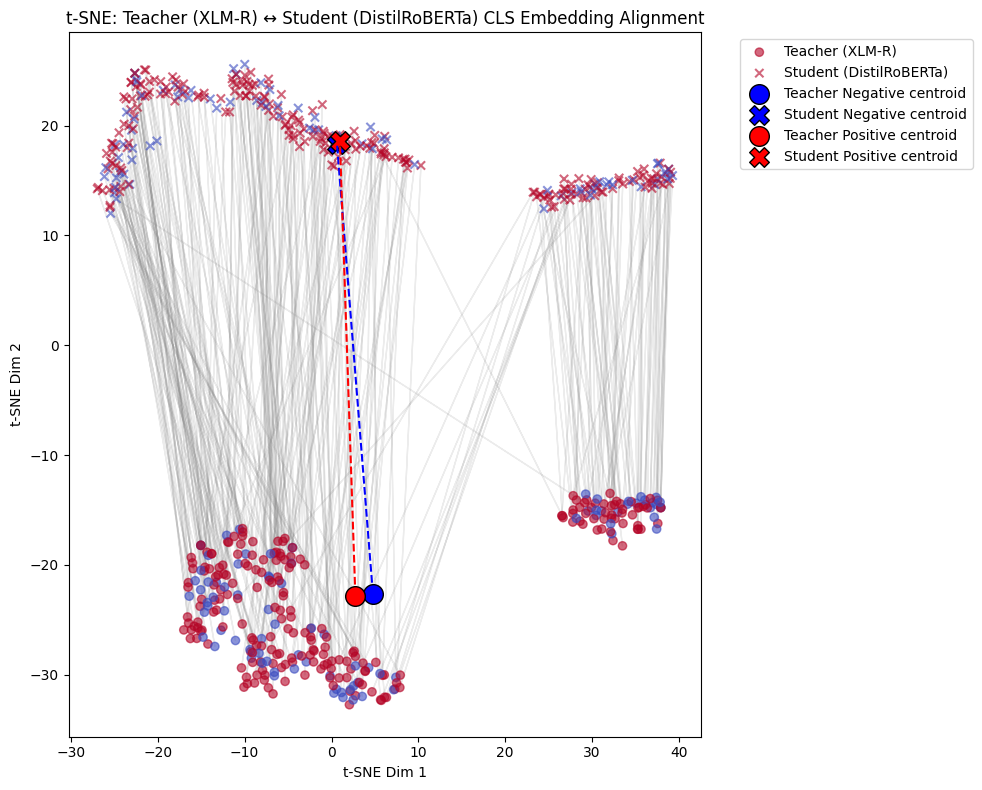

🧩 Mean teacher–student embedding cosine similarity: 0.7003


In [17]:
# ==============================================================
# 🧠 t-SNE Visualization: Teacher ↔ Student Alignment
# ==============================================================

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from sklearn.metrics.pairwise import cosine_similarity

teacher.eval()
student.eval()

# --- Sample subset for visualization ---
num_samples = 300  # smaller = faster
texts = random.sample(test_df.text.tolist(), k=min(num_samples, len(test_df)))
labels = np.array([test_df.label.tolist()[i] for i in range(len(texts))])

print(f"Visualizing {len(texts)} test samples...")

# --- Helper: extract [CLS] embeddings (handles dict or ModelOutput)
def extract_cls_embeddings(model, tokenizer, texts, batch_size=16, max_len=MAX_LEN):
    all_cls = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True, return_dict=True)
            # Handle both dict and ModelOutput types
            if isinstance(out, dict):
                hidden_states = out["hidden_states"]
            else:
                hidden_states = out.hidden_states
            cls_vec = hidden_states[-1][:, 0, :].detach().cpu().numpy()
        all_cls.append(cls_vec)
    return np.concatenate(all_cls, axis=0)

# --- Extract embeddings ---
print("Extracting teacher (XLM-R) CLS embeddings ...")
teacher_embs = extract_cls_embeddings(teacher, shared_tok, texts)
print("Extracting student (DistilRoBERTa) CLS embeddings ...")
student_embs = extract_cls_embeddings(student, shared_tok, texts)

# --- Run t-SNE ---
print("Running t-SNE (≈1–2 min) ...")
all_embs = np.concatenate([teacher_embs, student_embs], axis=0)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init="pca",
    learning_rate="auto",
    max_iter=1500   # ✅ changed from n_iter → max_iter
)
all_2d = tsne.fit_transform(all_embs)

n = len(texts)
teacher_2d, student_2d = all_2d[:n], all_2d[n:]

# --- Compute class centroids ---
centroids = {}
for label in np.unique(labels):
    centroids[(label, "teacher")] = teacher_2d[labels == label].mean(axis=0)
    centroids[(label, "student")] = student_2d[labels == label].mean(axis=0)

# --- Plot ---
plt.figure(figsize=(10, 8))

# Arrows teacher → student
for i in range(n):
    plt.arrow(
        teacher_2d[i, 0], teacher_2d[i, 1],
        student_2d[i, 0] - teacher_2d[i, 0],
        student_2d[i, 1] - teacher_2d[i, 1],
        color="gray", alpha=0.15, head_width=0.0, length_includes_head=True
    )

# Teacher points
plt.scatter(
    teacher_2d[:, 0], teacher_2d[:, 1],
    c=labels, cmap="coolwarm", marker="o", alpha=0.6, label="Teacher (XLM-R)"
)
# Student points
plt.scatter(
    student_2d[:, 0], student_2d[:, 1],
    c=labels, cmap="coolwarm", marker="x", alpha=0.6, label="Student (DistilRoBERTa)"
)

# Centroids and class connections
for label, color, name in [(0, "blue", "Negative"), (1, "red", "Positive")]:
    t_c = centroids[(label, "teacher")]
    s_c = centroids[(label, "student")]
    plt.scatter(*t_c, color=color, edgecolor="k", s=200, marker="o", label=f"Teacher {name} centroid")
    plt.scatter(*s_c, color=color, edgecolor="k", s=200, marker="X", label=f"Student {name} centroid")
    plt.plot([t_c[0], s_c[0]], [t_c[1], s_c[1]], color=color, linestyle="--", linewidth=1.5)

plt.title("t-SNE: Teacher (XLM-R) ↔ Student (DistilRoBERTa) CLS Embedding Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.show()

# --- Numeric embedding alignment score ---
alignment_score = cosine_similarity(teacher_embs, student_embs).diagonal().mean()
print(f"🧩 Mean teacher–student embedding cosine similarity: {alignment_score:.4f}")
